## Imports

In [2]:
import h5py
import numpy as np
import scipy as sp
import skimage as ski
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from ipywidgets import interact

from fusion import optimize, optimize_with_continuous_time
from baseline import baseline
from utils import (
    RESOURCES_PATH,
    spectral_volume_to_srgb,
    get_discrete_time_decay,
    bin_data,
    load_raw_spc,
    calibrate_spc,
    cut_spc,
    bin_spc,
    reconstruct_spc,
)


LAMBDA_PATH = RESOURCES_PATH / "kidney2" / "610_Lambda_L16.mat"
CMOS_PATH = RESOURCES_PATH / "kidney2" / "kidney2_520_4m_rec_FOVcorrected.mat"
SPC_PATH = RESOURCES_PATH / "kidney2" / "valerio" / "520_kidney2_550_550_610_SPC_raw_proc_tlxy_bin200ps_cut.mat"
SPC_ZOOMED_PATH = RESOURCES_PATH / "kidney2" / "valerio" / "520_kidney2_128_550_550_610_SPC_raw_proc_tlxy_bin200ps_cut.mat"
# SPC_PATH = RESOURCES_PATH / "kidney2" / "520_kidney2_550_550_610_SPC_calib_cut_binned_tlxy.npz"
# SPC_ZOOMED_PATH = RESOURCES_PATH / "kidney2" / "520_kidney2_128_550_550_610_SPC_calib_cut_binned_tlxy.npz"

# LAMBDA_PATH = RESOURCES_PATH / "beads" / "575_Lambda_L16.mat"
# CMOS_PATH = RESOURCES_PATH / "beads" / "3beads_triangle_w4_rec_Hil2D_FOVcorrected.mat"
# SPC_PATH = RESOURCES_PATH / "beads" / "480_3beads_triangle_505_500_575_SPC_raw_proc_tlxy.mat"

# CMOS_PATH = RESOURCES_PATH / "kidney_cells_520_610_w4_rec_Hil2D_FOVcorrected.mat"
# SPC_PATH = RESOURCES_PATH / "520_kidneyCells_550_550_610_SPC_raw_proc_tlxy.mat"
# LAMBDA_PATH = RESOURCES_PATH / "610_Lambda_L16.mat"

PREPROCESS = False
XY_DIM = 128
Z_START = 6
Z_END = 15

## SPC preprocessing

In [3]:
if PREPROCESS:
    KIDNEY2_PATH = RESOURCES_PATH / "kidney2"
    RAW_SPC_PATH = KIDNEY2_PATH / "520_kidney2_550_550_610_SPC_raw.mat"
    RECONSTRUCTION_SAVE_PATH = KIDNEY2_PATH / "520_kidney2_550_550_610_SPC_calib_cut_binned_tlxy.npz"
    SH_PATH = KIDNEY2_PATH / "FLIM_Scrambled-Hadamard_1024.mat"
    EFFICIENCY_CALIB_PATH = KIDNEY2_PATH / "Efficiency_L16_610.mat"
    OFFSET_CALIB_PATH = KIDNEY2_PATH / "L16_temporal_offsets_20220520.mat"
    TEMPORAL_AXIS_PATH = KIDNEY2_PATH / "t.npy"
    
    spc = load_raw_spc(RAW_SPC_PATH)  # (n_times, n_spectra, n_measurements)
    forward_matrix = sp.io.loadmat(SH_PATH)["M"].astype(np.float64)[::2]  # (n_measurements, pattern_size)
    t = np.load(TEMPORAL_AXIS_PATH).flatten().astype(np.float64)  # (n_times,)
    
    spc_calib = calibrate_spc(spc, EFFICIENCY_CALIB_PATH, OFFSET_CALIB_PATH)
    spc_calib_cut, t_cut = cut_spc(spc_calib, t, max_times=2048)
    spc_calib_cut_binned, t_cut_binned, dt_cut_binned = bin_spc(spc_calib_cut, t_cut, n_bins=32)
    spc_recon = reconstruct_spc(
        spc_calib_cut_binned,
        forward_matrix,
        algo=nnls,
        n_jobs=8,
    )  # (n_times, n_spectra, img_dim, img_dim)
    np.savez_compressed(
        RECONSTRUCTION_SAVE_PATH,
        spc_recon=spc_recon,
        t_cut_binned=t_cut_binned,
        dt_cut_binned=dt_cut_binned,
    )

## Data loading

In [4]:
with h5py.File(CMOS_PATH, "r") as f:
    cmos = np.array(f["I"])
    cmos = np.transpose(cmos, (1, 2, 0))
    cmos = ski.transform.resize(cmos, (XY_DIM, XY_DIM, cmos.shape[2]))
    cmos = np.transpose(cmos, (2, 1, 0))
    cmos = cmos[Z_START:Z_END]

spc = sp.io.loadmat(SPC_PATH)["im"]
t = np.squeeze(sp.io.loadmat(SPC_ZOOMED_PATH)["t"])
gt_spc = sp.io.loadmat(SPC_ZOOMED_PATH)["im"]
# spc = np.load(SPC_PATH)["spc_recon"].swapaxes(-2, -1)
# t = np.load(SPC_PATH)["t_cut_binned"]
# gt_spc = np.load(SPC_ZOOMED_PATH)["arr_0"].swapaxes(-2, -1)

# FIXME: Replace with correct [0,0] pixel.
spc[:, :, 0, 0] = spc[:, :, 1, 0]
gt_spc[:, :, 0, 0] = gt_spc[:, :, 1, 0]

t = t - t.min()
dt = t[1] - t[0]
lam = np.squeeze(sp.io.loadmat(LAMBDA_PATH)["lambda"])

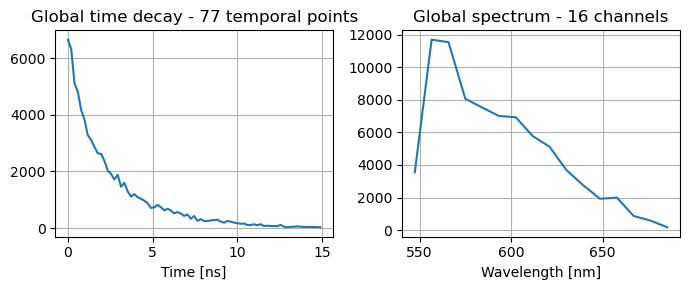

In [5]:
_, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].plot(t, spc.sum(axis=(1, 2, 3)))
ax[0].set_title(f"Global time decay - {len(t)} temporal points")
ax[0].set_xlabel("Time [ns]")
ax[0].grid()

ax[1].plot(lam, spc.sum(axis=(0, 2, 3)))
ax[1].set_title(f"Global spectrum - {len(lam)} channels")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].grid()

plt.tight_layout()
plt.show()

In [6]:
cmos_energy = cmos.sum()
spc_energy = spc.sum()
gt_spc_energy = gt_spc.sum()

cmos_max = cmos / cmos.max()
spc_max = spc / spc.max()
gt_spc_max = gt_spc / gt_spc.max()

cmos /= cmos_energy
spc /= spc_energy
gt_spc /= gt_spc_energy

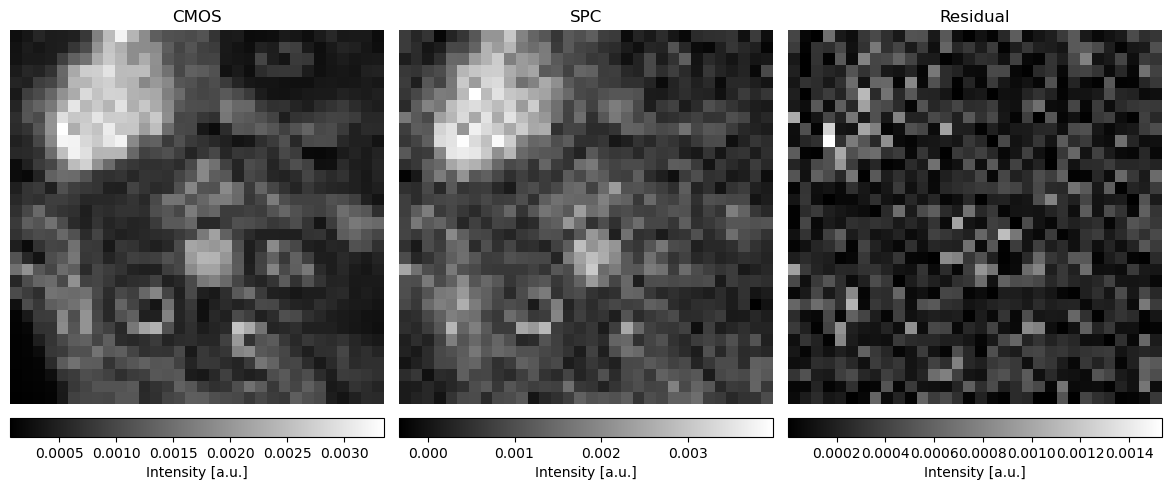

In [7]:
import torch

down_sampler = torch.nn.LPPool2d(1, (4, 4), (4, 4))
cmos_down_sampled = down_sampler(torch.tensor(cmos)).numpy().sum(axis=0)

fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1])
ax0 = fig.add_subplot(gs[0, 0])

img = ax0.imshow(cmos_down_sampled, cmap="gray")
ax0.set_title("CMOS")
ax0.axis("off")
fig.colorbar(img, ax=ax0, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")

ax1 = fig.add_subplot(gs[0, 1])
img = ax1.imshow(spc.sum(axis=(0, 1)), cmap="gray")
ax1.set_title("SPC")
ax1.axis("off")
fig.colorbar(img, ax=ax1, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")

ax2 = fig.add_subplot(gs[0, 2])
img = ax2.imshow(np.abs(cmos_down_sampled - spc.sum(axis=(0, 1))), cmap="gray")
ax2.set_title("Residual")
ax2.axis("off")
fig.colorbar(img, ax=ax2, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")

plt.tight_layout()
plt.show()


In [8]:
initial_spectrums = np.sum(spc, axis=0)
min_spectrums, max_spectrums = np.min(initial_spectrums), np.max(initial_spectrums)

initial_times = np.sum(spc, axis=1)
min_times, max_times = np.min(initial_times), np.max(initial_times)

resolution_diff_factor = int(cmos.shape[-1] / spc.shape[-1])


def spc_spectrum_time_in_a_point(z=5, i=19, j=17):
    _, ax = plt.subplots(1, 4, figsize=(12, 3))
    ax[0].imshow(cmos_max[z], cmap="gray", vmin=0, vmax=1)
    ax[0].scatter([j * resolution_diff_factor], [i * resolution_diff_factor], c="w")
    ax[0].set_title(f"CMOS in {z}")

    ax[1].imshow(spectral_volume_to_srgb(lam, spc.sum(axis=0)[:, np.newaxis])[0])
    ax[1].scatter([j], [i], c="w")
    ax[1].set_title(f"Colored with spectrum")

    ax[2].plot(lam, initial_spectrums[:, i, j])
    ax[2].set_ylim(min_spectrums, max_spectrums)
    ax[2].set_title(f"Spectrum in ({i},{j})")
    ax[2].grid()

    ax[3].plot(t, initial_times[:, i, j])
    ax[3].set_ylim(min_times, max_times)
    ax[3].set_title(f"Time in ({i},{j})")
    ax[3].grid()

    plt.tight_layout()
    plt.show()


interact(
    spc_spectrum_time_in_a_point,
    z=(0, cmos.shape[0] - 1, 1),
    i=(0, spc.shape[-2] - 1, 1),
    j=(0, spc.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=5, description='z', max=8), IntSlider(value=19, description='i', max=31)…

## Fusion through optimization

In [9]:
print(f"Machine precision: {np.finfo(np.float64).eps}")
print(f"SPC dtype: {spc.dtype}", f"CMOS dtype: {cmos.dtype}")

weights = {
    "spatial": 10,
    "lambda_time": 100,
    "global": 0.0001,
}

x = optimize(
    spc,
    cmos,
    weights=weights,
    lr=1e-5,
    iterations=150,
    device="cpu",
    init_type="random",
    mask_initializations=False,
    mask_gradients=False,
    non_neg=True,
    return_numpy=True,
)

Machine precision: 2.220446049250313e-16
SPC dtype: float64 CMOS dtype: float64


/Users/cris/miniforge3/envs/deepspc/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1715184404505/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
Spatial: 9.009180647052752e-11 | Lambda Time: 1.3154163891895407e-09 | Global: 3.0925596303199694e-11 | : 100%|██████████| 150/150 [02:26<00:00,  1.02it/s]


In [11]:
print(x.sum(), cmos.sum(), spc.sum())

1.42749167141515 1.0000000000000002 0.9999999999999997


## Fusion through optimization with continuous time

In [ ]:
weights = {
    "spectral": 1.0,
    "time": 2.0,
    "spatial": 0.1,
    "spectral_time": 0.0,
}

# spc_denoised = np.zeros_like(spc)
# for li in range(spc.shape[0]):
#     for yi in range(spc.shape[3]):
#         for xi in range(spc.shape[2]):
#             spc_denoised[li, :, xi, yi] = wavelet_denoising(spc[li, :, xi, yi], wavelet="db2", threshold=0.1)

x = optimize_with_continuous_time(
    spc,
    cmos,
    weights=weights,
    t=np.arange(0.00001, dt * len(t), dt),
    n_decays=1,
    lr=0.005,
    iterations=1000,
    device="cpu",
    init_type="random",
    mask_initializations=False,
    mask_gradients=False,
    non_neg=True,
    return_numpy=False,
)

# If you use optimize with continuous time, you can use this to get the discrete time decay
x_cont = x.cpu().detach().numpy().copy()

x = get_discrete_time_decay(x.detach(), np.arange(0.00001, dt * len(t), dt))
x = x.cpu().numpy()

## Fusion through baseline

In [12]:
x_baseline = baseline(cmos, spc, device="cpu", return_numpy=True)

100%|██████████| 77/77 [00:00<00:00, 332.35it/s]


## Visualize results

In [13]:
slices_rgb = spectral_volume_to_srgb(lam, np.mean(x, axis=0))
slices_rgb_baseline = spectral_volume_to_srgb(lam, np.mean(x_baseline, axis=0))

means_spectrums = np.sum(x, axis=(0, 3, 4)).T
min_mean_spectrum = np.min(means_spectrums)
max_mean_spectrum = np.max(means_spectrums)

means_times = np.sum(x, axis=(1, 3, 4)).T
min_mean_times = np.min(means_times)
max_mean_times = np.max(means_times)

zxy = np.mean(x, axis=(0, 1))
zxy /= zxy.max()


def plot_across_z(z=5, i=0, j=0):
    _, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax[0, 0].imshow(slices_rgb_baseline[z])
    ax[0, 0].scatter([j], [i], c="w")
    ax[0, 0].set_title(f"Baseline z={z}")

    ax[1, 1].plot(lam, means_spectrums[z])
    ax[1, 1].set_ylim(min_mean_spectrum, max_mean_spectrum)
    ax[1, 1].set_title(f"Global Spectrum in z={z}")
    ax[1, 1].grid()

    ax[1, 2].plot(t, means_times[z])
    ax[1, 2].set_ylim(min_mean_times, max_mean_times)
    ax[1, 2].set_title(f"Global Time in z={z}")
    ax[1, 2].grid()

    reconstructed_spectrums = np.sum(x[:, :, z, :, :], axis=0)
    baseline_spectrums = np.sum(x_baseline[:, :, z, :, :], axis=0)
    lxy_spc = np.sum(spc, axis=0)

    reconstructed_times = np.sum(x[:, :, z, :, :], axis=1)
    baseline_times = np.sum(x_baseline[:, :, z, :, :], axis=1)
    txy_spc = np.sum(spc, axis=1)

    ax[1, 0].imshow(slices_rgb[z])
    ax[1, 0].scatter([j], [i], c="w")
    ax[1, 0].set_title(f"Reconstruction Spectral Colored z={z}")

    ax[0, 1].plot(lam, reconstructed_spectrums[:, i, j] * 15 * 16, label="Datafusion")
    ax[0, 1].plot(lam, baseline_spectrums[:, i, j], label="Baseline")
    ax[0, 1].plot(lam, lxy_spc[:, i // 4, j // 4], label="SPC")
    ax[0, 1].set_title(f"Spectrum in ({i},{j})")
    ax[0, 1].legend(loc="upper right")
    ax[0, 1].grid()

    ax[0, 2].plot(t - t.min(), reconstructed_times[:, i, j] * 15 * 16, label="Datafusion")
    ax[0, 2].plot(t - t.min(), baseline_times[:, i, j], label="Baseline")
    ax[0, 2].plot(t - t.min(), txy_spc[:, i // 4, j // 4], label="SPC")
    ax[0, 2].set_title(f"Time in ({i},{j})")
    ax[0, 2].legend(loc="upper right")
    ax[0, 2].grid()

    plt.tight_layout()
    plt.show()


interact(
    plot_across_z,
    z=(0, len(zxy) - 1, 1),
    i=(0, x.shape[-2] - 1, 1),
    j=(0, x.shape[-1] - 1, 1),
);

interactive(children=(IntSlider(value=5, description='z', max=8), IntSlider(value=0, description='i', max=127)…


## Plot results

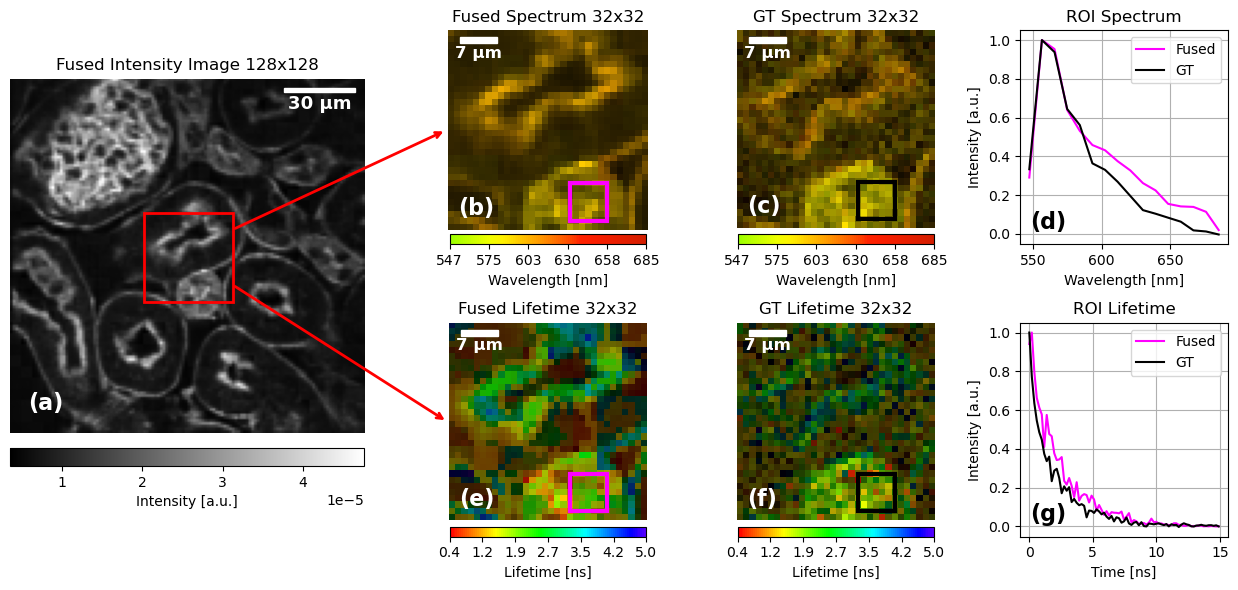

In [20]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import patches
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from utils import (
    R, G, B, WAVELENGTHS,
    spectral_volume_to_srgb,
    FIGURES_PATH,
)


def decay(t, A, tau, c):
    return A * np.exp(-t / tau) + c


def time_image_to_lifetime(t, img, max_value):
    a_out = np.zeros((img.shape[1], img.shape[2]), dtype=np.float64)
    tau_out = np.zeros((img.shape[1], img.shape[2]), dtype=np.float64)
    c_out = np.zeros((img.shape[1], img.shape[2]), dtype=np.float64)
    intensity_image = img.sum(axis=0)
    intensity_image /= intensity_image.max()

    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            # if intensity_image[i, j] < 0.0:
            #     a_out[i, j] = 0
            #     tau_out[i, j] = 0
            #     c_out[i, j] = 0
            # 
            # else:
            params, covariance = curve_fit(
                decay,
                t,
                img[:, i, j],
                bounds=([0.0, 0.0, 0.0], [max_value, 5.0, 0.1]),
                p0=(max_value / 2.0, 2.0, 0.000001),
                maxfev=5000,
            )
            a_out[i, j] = params[0]
            tau_out[i, j] = params[1]
            c_out[i, j] = params[2]

    return a_out, tau_out, c_out


def plot_zoom_results(
        x, t, lam,
        gt_spc,
        z_index,
        zoom_slice=slice(48, 80),
        roi_u=slice(24, 30),
        roi_v=slice(19, 25),
        font_size_letters=16,
        save_name=None,
):
    # Defining spectral colorbar
    spectral_colors = np.array([(r, g, b) for r, g, b in zip(R, G, B)])
    spectral_cmap = LinearSegmentedColormap.from_list("spectrum", spectral_colors, N=100)

    # Defining fused scalebar
    fused_micro_width = 150  # in micrometers
    pixel_size = fused_micro_width / x.shape[-1]
    scalebar_length_micrometers = 30
    scalebar_length_pixels = scalebar_length_micrometers / pixel_size

    # Defining zoomed scalebar
    zoomed_micro_width = 150 / (x.shape[-1] / gt_spc.shape[-1])
    pixel_size = zoomed_micro_width / gt_spc.shape[-1]
    scalebar_length_micrometers_zoomed = 7
    scalebar_length_pixels_zoomed = scalebar_length_micrometers_zoomed / pixel_size

    fused_intensity = x.sum(axis=(0, 1))[z_index]

    # Defining the fused zoomed tensors
    fused_zoomed = x[:, :, z_index:z_index + 1, zoom_slice, zoom_slice]
    fused_zoomed_spectral = spectral_volume_to_srgb(lam, fused_zoomed.sum(axis=0))[0]
    tmp = fused_zoomed.sum(axis=1)[:, 0]
    tmp /= tmp.sum()
    fused_zoomed_a, fused_zoomed_tau, fused_zoomed_c = time_image_to_lifetime(t, tmp, tmp.max())

    fused_zoomed_tau_min = fused_zoomed_tau.min()
    fused_zoomed_tau_max = fused_zoomed_tau.max()
    fused_h = (260 / 360) * (
            1 - ((fused_zoomed_tau_max - fused_zoomed_tau) / (fused_zoomed_tau_max - fused_zoomed_tau_min)))
    fused_s = np.ones_like(fused_zoomed_tau)
    fused_v = fused_zoomed_a / fused_zoomed_a.max()
    fused_lifetime_image = hsv_to_rgb(np.stack([fused_h, fused_s, fused_v], axis=-1))

    # Defining the ground truth zoomed tensors
    gt_spc_spectral = spectral_volume_to_srgb(lam, gt_spc.sum(axis=0)[:, np.newaxis])[0]
    tmp = gt_spc.sum(axis=1)
    tmp /= tmp.sum()
    gt_spc_a, gt_spc_tau, gt_spc_tau_c = time_image_to_lifetime(t, tmp, tmp.max())

    gt_spc_tau_min = gt_spc_tau.min()
    gt_spc_tau_max = gt_spc_tau.max()
    gt_h = (260 / 360) * (1 - ((gt_spc_tau_max - gt_spc_tau) / (
            gt_spc_tau_max - gt_spc_tau_min)))
    gt_s = np.ones_like(gt_spc_tau)
    gt_v = gt_spc_a / gt_spc_a.max()
    ground_truth_lifetime_image = hsv_to_rgb(np.stack([gt_h, gt_s, gt_v], axis=-1))

    fig = plt.figure(figsize=(12.5, 6))
    gs = fig.add_gridspec(2, 4, width_ratios=[1.7, 1, 1, 1], height_ratios=[1, 1])

    # Plot fused intensity
    ax0 = fig.add_subplot(gs[:, 0])
    fused_0 = ax0.imshow(fused_intensity, cmap='gray')
    ax0.set_title(f"Fused Intensity Image {fused_intensity.shape[-1]}x{fused_intensity.shape[-1]}")
    ax0.add_patch(patches.Rectangle(
        (zoom_slice.start, zoom_slice.start),
        zoom_slice.stop - zoom_slice.start,
        zoom_slice.stop - zoom_slice.start,
        linewidth=2, edgecolor='red', facecolor='none')
    )
    ax0.text(0.05, 0.05, "(a)", transform=ax0.transAxes, fontsize=font_size_letters,
             fontweight='bold', va='bottom', c="w")
    scalebar = AnchoredSizeBar(
        ax0.transData,
        scalebar_length_pixels,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers} µm',  # Label for the scalebar
        'upper right',
        pad=0.4,
        color='white',
        frameon=False,
        size_vertical=1.5,
        fontproperties={"size": 13, "weight": "bold"},
    )
    ax0.add_artist(scalebar)
    ax0.axis("off")

    # Spectral comparison
    ax01 = fig.add_subplot(gs[0, 1])
    zoom01 = ax01.imshow(fused_zoomed_spectral, cmap=spectral_cmap)
    ax01.set_title(f"Fused Spectrum {fused_zoomed_spectral.shape[0]}x{fused_zoomed_spectral.shape[0]}")
    ax01.text(0.05, 0.05, "(b)", transform=ax01.transAxes, fontsize=font_size_letters,
              fontweight='bold', va='bottom', c="w")
    ax01.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="magenta", facecolor='none')
    )
    scalebar = AnchoredSizeBar(
        ax01.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax01.add_artist(scalebar)
    ax01.axis("off")

    ax02 = fig.add_subplot(gs[0, 2])
    zoom02 = ax02.imshow(gt_spc_spectral, cmap=spectral_cmap)
    ax02.set_title(f"GT Spectrum {gt_spc_spectral.shape[0]}x{gt_spc_spectral.shape[0]}")
    ax02.text(0.05, 0.05, "(c)", transform=ax02.transAxes, fontsize=font_size_letters, fontweight='bold', va='bottom',
              c="w")
    ax02.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="black", facecolor='none')
    )
    scalebar = AnchoredSizeBar(
        ax02.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax02.add_artist(scalebar)
    ax02.axis("off")

    ax03 = fig.add_subplot(gs[0, 3])
    tmp = fused_zoomed[:, :, 0, roi_u, roi_v].sum(axis=(0, 2, 3))
    ax03.plot(lam, tmp / tmp.max(), label="Fused", c="magenta")
    tmp = gt_spc[:, :, roi_u, roi_v].sum(axis=(0, 2, 3))
    ax03.plot(lam, tmp / tmp.max(), label="GT", c="black")
    ax03.set_title("ROI Spectrum")
    ax03.set_xlabel("Wavelength [nm]")
    ax03.set_ylabel("Intensity [a.u.]")
    ax03.legend()
    ax03.grid()
    ax03.text(0.05, 0.05, "(d)", transform=ax03.transAxes, fontsize=font_size_letters, fontweight='bold', va='bottom')

    # Lifetime comparison
    max_h = max(fused_h.max(), gt_h.max())
    tau_min = min(fused_zoomed_tau_min, gt_spc_tau_min)
    tau_max = max(fused_zoomed_tau_max, gt_spc_tau_max)
    hsv_colormap = np.vstack([np.linspace(0, max_h, 100), np.ones(100), np.ones(100)]).T
    fused_lifetime_cmap = LinearSegmentedColormap.from_list("fused_lifetime", hsv_to_rgb(hsv_colormap), N=100)
    hsv_colormap = np.vstack([np.linspace(0, max_h, 100), np.ones(100), np.ones(100)]).T
    gt_lifetime_cmap = LinearSegmentedColormap.from_list("gt_lifetime", hsv_to_rgb(hsv_colormap), N=100)

    ax11 = fig.add_subplot(gs[1, 1])
    zoom11 = ax11.imshow(fused_lifetime_image, cmap=fused_lifetime_cmap)
    ax11.set_title(f"Fused Lifetime {fused_zoomed_tau.shape[-1]}x{fused_zoomed_tau.shape[-1]}")
    ax11.text(0.05, 0.05, "(e)", transform=ax11.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom",
              c="w")
    ax11.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="magenta", facecolor='none'))
    scalebar = AnchoredSizeBar(
        ax11.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax11.add_artist(scalebar)
    ax11.axis("off")

    ax12 = fig.add_subplot(gs[1, 2])
    zoom12 = ax12.imshow(ground_truth_lifetime_image, cmap=gt_lifetime_cmap)
    ax12.set_title(f"GT Lifetime {gt_spc_tau.shape[-1]}x{gt_spc_tau.shape[-1]}")
    ax12.text(0.05, 0.05, "(f)", transform=ax12.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom",
              c="w")
    ax12.add_patch(patches.Rectangle(
        (roi_v.start, roi_u.start),
        roi_v.stop - roi_v.start,
        roi_u.stop - roi_u.start,
        linewidth=3, edgecolor="black", facecolor='none'))
    scalebar = AnchoredSizeBar(
        ax12.transData,
        scalebar_length_pixels_zoomed,  # Length of scalebar in pixels
        f'{scalebar_length_micrometers_zoomed} µm',  # Label for the scalebar
        'upper left',
        pad=0.3,
        color='white',
        frameon=False,
        size_vertical=1,
        fontproperties={"size": 12, "weight": "bold"},
    )
    ax12.add_artist(scalebar)
    ax12.axis("off")

    ax13 = fig.add_subplot(gs[1, 3])
    tmp = fused_zoomed[:, :, 0, roi_u, roi_v].sum(axis=(1, 2, 3))
    tmp /= tmp.max()
    ax13.plot(t, tmp, label="Fused", c="magenta")
    tmp = gt_spc[:, :, roi_u, roi_v].sum(axis=(1, 2, 3))
    tmp /= tmp.max()
    ax13.plot(t, tmp, label="GT", c="black")
    ax13.set_title("ROI Lifetime")
    ax13.set_xlabel("Time [ns]")
    ax13.set_ylabel("Intensity [a.u.]")
    ax13.legend()
    ax13.grid()
    ax13.text(0.05, 0.05, "(g)", transform=ax13.transAxes, fontsize=font_size_letters, fontweight="bold", va="bottom")

    # Spectral color bars
    fig.colorbar(fused_0, ax=ax0, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")
    cbar = fig.colorbar(zoom01, ax=ax01, fraction=0.046, pad=0.02, orientation="horizontal", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(WAVELENGTHS[::3])))
    cbar.set_ticklabels([f"{w:.0f}" for w in WAVELENGTHS[::3]])

    cbar = fig.colorbar(zoom02, ax=ax02, fraction=0.046, pad=0.03, orientation="horizontal", label="Wavelength [nm]")
    cbar.set_ticks(np.linspace(0, 1, len(WAVELENGTHS[::3])))
    cbar.set_ticklabels([f"{w:.0f}" for w in WAVELENGTHS[::3]])

    # Lifetime color bars
    cbar = fig.colorbar(zoom11, ax=ax11, fraction=0.046, pad=0.03, orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 7))
    cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_min, tau_max, 7)])

    cbar = fig.colorbar(zoom12, ax=ax12, fraction=0.046, pad=0.03, orientation="horizontal", label="Lifetime [ns]")
    cbar.set_ticks(np.linspace(0, 1, 7))
    cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_min, tau_max, 7)])

    ax0.annotate(
        "", xy=(-0.01, 0.5), xytext=(zoom_slice.stop, 54),
        xycoords=ax01.transAxes, textcoords="data",
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

    ax0.annotate(
        "", xy=(-0.01, 0.5), xytext=(zoom_slice.stop, 74),
        xycoords=ax11.transAxes, textcoords="data",
        arrowprops=dict(arrowstyle="->", color="red", lw=2)
    )

    plt.tight_layout()

    if save_name:
        plt.savefig(FIGURES_PATH / save_name, dpi=300)

    plt.show()

    return fused_zoomed_a, fused_zoomed_tau, fused_zoomed_c, fused_zoomed.sum(axis=1)[:, 0]


a_out, fused_out, c_out, img_out = plot_zoom_results(
    x, t, lam, gt_spc,
    z_index=5,
    save_name=None,  # "results_kidney2.pdf",
    zoom_slice=slice(48, 80),
    roi_u=slice(24, 30),
    roi_v=slice(19, 25),
    # roi_u=slice(6, 12), 
    # roi_v=slice(22, 28),
)

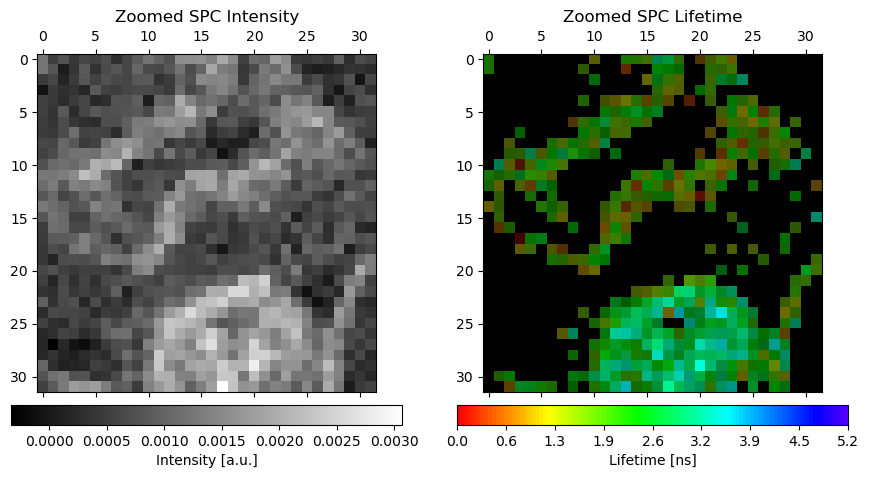

In [28]:
from scipy.optimize import curve_fit
from matplotlib.colors import hsv_to_rgb, LinearSegmentedColormap


def decay(t, A, tau, c):
    return A * np.exp(-t / tau) + c


def time_image_to_lifetime(t, img, max_value):
    a_out = np.zeros((img.shape[1], img.shape[2]), dtype=np.float64)
    tau_out = np.zeros((img.shape[1], img.shape[2]), dtype=np.float64)
    c_out = np.zeros((img.shape[1], img.shape[2]), dtype=np.float64)
    intensity_image = img.sum(axis=0)
    intensity_image /= intensity_image.max()

    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            if intensity_image[i, j] < 0.6:
                a_out[i, j] = 0
                tau_out[i, j] = 0
                c_out[i, j] = 0

            else:
                params, covariance = curve_fit(
                    decay,
                    t,
                    img[:, i, j],
                    bounds=([0.0, 0.0, 0.0], [max_value, 8.0, 0.001]),
                    p0=(max_value / 2.0, 2.0, 0.000001),
                    maxfev=5000,
                )
                a_out[i, j] = params[0]
                tau_out[i, j] = params[1]
                c_out[i, j] = params[2]

    return a_out, tau_out, c_out


new_spc = np.where(gt_spc < 0, 0, gt_spc)
new_spc = new_spc.sum(axis=1)

fig = plt.figure(figsize=(9, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], height_ratios=[1])
ax0 = fig.add_subplot(gs[0, 0])

img = ax0.matshow(gt_spc.sum(axis=(0, 1)), cmap="gray")
ax0.set_title("Zoomed SPC Intensity")
fig.colorbar(img, ax=ax0, fraction=0.175, pad=0.03, orientation="horizontal", label="Intensity [a.u.]")

a_out, tau_out, c_out = time_image_to_lifetime(t, new_spc, new_spc.max())
tau_min = tau_out.min()
tau_max = tau_out.max()
h = (260 / 360) * (1 - ((tau_out - tau_min) / (tau_max - tau_min)))
s = np.ones_like(tau_out)
v = a_out / a_out.max()

lifetime_hsv = np.stack([h, s, v], axis=-1)
lifetime_image = hsv_to_rgb(lifetime_hsv)

# hsv_colormap = np.vstack([np.linspace(0, 260 / 360, 100), np.ones(100), np.ones(100)]).T
hsv_colormap = np.vstack([np.linspace(0, h.max(), 100), np.ones(100), np.ones(100)]).T
lifetime_cmap = LinearSegmentedColormap.from_list("lifetime", hsv_to_rgb(hsv_colormap), N=100)

ax1 = fig.add_subplot(gs[0, 1])
img = ax1.matshow(lifetime_image, cmap=lifetime_cmap)
ax1.set_title("Zoomed SPC Lifetime")
cbar = fig.colorbar(img, ax=ax1, fraction=0.175, pad=0.03, orientation="horizontal", label="Lifetime [ns]")
cbar.set_ticks(np.linspace(0, 1, 9))
cbar.set_ticklabels([f"{t:.1f}" for t in np.linspace(tau_min, tau_max, 9)])

plt.tight_layout()
plt.show()

In [22]:
h.min()

0.0

In [ ]:
def plot_decay(i=3, j=0):
    a, tau, c = a_out[i, j], tau_out[i, j], c_out[i, j]
    plt.scatter(t, img_out[:, i, j])
    plt.plot(t, decay(t, a, tau, c), c="r")
    plt.title(f"A: {a:.2F} | Tau: {tau:.2F} | c: {c:.2E}")
    plt.grid()
    plt.show()


interact(plot_decay, i=(0, img_out.shape[1] - 1, 1), j=(0, img_out.shape[2] - 1, 1));